# RL Exercise Demo
This exercise serves as a demonstration how to quickly train an RL agent on a popular environment with a RL framework.
We will
1. Select and instantiate and environment (gym's BipedalWalker-v3).
2. Select and setup our RL algorithm / agent (stablebaselines3 [SAC](https://spinningup.openai.com/en/latest/algorithms/sac.html)).
3. Train the agent on the environment and visualize training progress.
4. Evaluate our agent and observe the distribution of test performances.
5. Record and replay the agent, before and after.
5. Optimize the agent's hyperparameters with SMAC.

## The Environment: Bipedal Walker
![Bipedal Walker](bipedal_walker.gif) [credits](https://www.gymlibrary.dev/_images/bipedal_walker.gif)

### Env
- locomotion
- 4 joints

### Action Space
- motor speed for all 4 joints (hips and knees) [-1, 1]

### Observation Space
State consists of
- hull angle speed
- angular velocity
- horizontal speed
- vertical speed
- position of joints
- joints angular speed
- legs contact with ground
- 10 lidar rangefinder measurements

There are no coordinates! State vector with 24 entries.

### Rewards
Moving forward gives rewards.
Falling is punished.
Applying motor torque costs a little.


### Starting State
Stands at the left in a certain position.

### Episode Termination
- walker falls
- or reaches end of terrain


In [1]:
import pandas as pd

model_fn = "trained_agent.zip"
env_id = "BipedalWalker-v3"
log_dir = "logs/tensorboard"

## The Agent: TQC
[todo add paper]

In [2]:
import gym
from stable_baselines3 import SAC

env = gym.make(env_id)
model = SAC("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
model.learn(total_timesteps=500_000)
model.save(model_fn)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/tensorboard/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 458      |
|    ep_rew_mean     | -102     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 103      |
|    time_elapsed    | 17       |
|    total_timesteps | 1834     |
| train/             |          |
|    actor_loss      | -17.1    |
|    critic_loss     | 0.328    |
|    ent_coef        | 0.595    |
|    ent_coef_loss   | -3.46    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1733     |
---------------------------------


KeyboardInterrupt: 

# Rollout

In [3]:
video_folder = "logs/videos/"
video_length = 1000

## Record random agent

In [ ]:
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env = DummyVecEnv([lambda: gym.make(env_id)])

env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix=f"random-agent-{env_id}",
)

n_steps = video_length

obs = env.reset()
for i in range(n_steps):
    action = [env.action_space.sample()]
    obs, reward, done, info = env.step(action)
    if done:
        break
        obs = env.reset()
env.close()

## Record trained agent

In [ ]:
from stable_baselines3 import SAC
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env = DummyVecEnv([lambda: gym.make(env_id)])

# Record the video starting at the first step
env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix=f"trained-agent-{env_id}",
)

model = SAC.load(model_fn)

n_steps = video_length

obs = env.reset()
for i in range(n_steps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
        break
        obs = env.reset()
env.close()

## Optimize Hyperparameters
Often RL algorithms don't converge if the hyperparameters are not configured properly. Or we just want to find out whether we could increase performance further.
For this optimize the hyperparameters (HPs) of the RL algorithm/agent.

### What Hyperparameters to Optimize?
We do not optimize every possible hyperparameter but focus on those which often have a high impact on the learning dynamics, such as the learning rate (step size) or gamma. 

### How to Set Up the Search Space?
For this we need to define our search space, that is, what values we allow for these HPs.
It is okay to set a broad range however if there is already an intuition we might set a smaller interval for searching.
This way we might get a better solution faster because of the smaller resulting search space.

### What Method to Use for Hyperparameter Optimization?
Oftentimes people rely on **manual search** for various reasons. However it is often more time-efficient if we use principled
and automated methods for the search. Another common approach is **grid search**.
This at first seems appealing because we humans like structure. For a HP search space it is better though to sample randomly
because we cover the search space way better, see the image below. **So use random search instead of grid search**.

<img src="grid_vs_random_search.png" alt="Grid Search vs Random Search" width="800">

[credits](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
Those approaches do not use past observed data points to try the next HP configuration.
**Bayesian Optimization (BO)** uses a model to incorporate seen data points to approximate the HP optimization landscape.
From this model we can smartly sample new HP configurations to try. BO therefore is really sample-efficient (does not need many evaluations/data points to find the optimum.
This of course also depends on the number of HPs we would like to optimize).
For this optimization we use [**SMAC**](https://github.com/automl/SMAC3) and especially a multi-fidelity approach (we don't always let the run finish but look early on how the progress and performance is), namely [BOHB](https://proceedings.mlr.press/v80/falkner18a.html).

### HPO Naming Conventions
- configuration = hyperparameters to use
- configuration space = search space, how we can set the hyperparameters
- incumbent = best configuration / hyperparameters found so far
- target algorithm = the function or algorithm we want to optimize (find the best hyperparameters for)
- trajectory = progress of incumbent value


In [13]:
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import gym
import numpy as np
from smac.scenario.scenario import Scenario
from smac.facade.smac_mf_facade import SMAC4MF
from smac.configspace import ConfigurationSpace, UniformFloatHyperparameter, Configuration

number_of_function_evaluations = 50
max_env_steps = 500_000

# Build configuration space
configuration_space = ConfigurationSpace()
gamma = UniformFloatHyperparameter(lower=0.9, upper=0.999, name="gamma", log=True)
learning_rate = UniformFloatHyperparameter(lower=5e-5, upper=5e-3, name="learning_rate", log=True)
configuration_space.add_hyperparameters([gamma, learning_rate])

# In order to use SMAC we need to package the model we want to optimize in a function
# In this case, SMAC minimizes therefore we want to return the negative performance
def target_algorithm(configuration: Configuration, budget: int) -> float:
    env = gym.make(env_id)
    model = SAC("MlpPolicy", env, verbose=0, gamma=configuration["gamma"], learning_rate=configuration["learning_rate"])
    model.learn(total_timesteps=budget)
    env = Monitor(gym.make(env_id))
    means, stds = evaluate_policy(model, env, n_eval_episodes=5)
    performance = np.mean(means)
    return -performance


# Intensifier parameters
intensifier_kwargs = {"initial_budget": 5000, "max_budget": max_env_steps, "eta": 4}

# Setup SMAC
scenario = Scenario(
    {
        "run-obj": "quality",  # optimize performance
        "runcount-limit": number_of_function_evaluations,
        "cs": configuration_space,
        "output_dir": "logs/smac",
    }
)
smac = SMAC4MF(scenario=scenario, tae_runner=target_algorithm, intensifier_kwargs=intensifier_kwargs, n_jobs=8)

# Let's go, optimize!
try:
    incumbent = smac.optimize()
finally:
    incumbent = smac.solver.incumbent

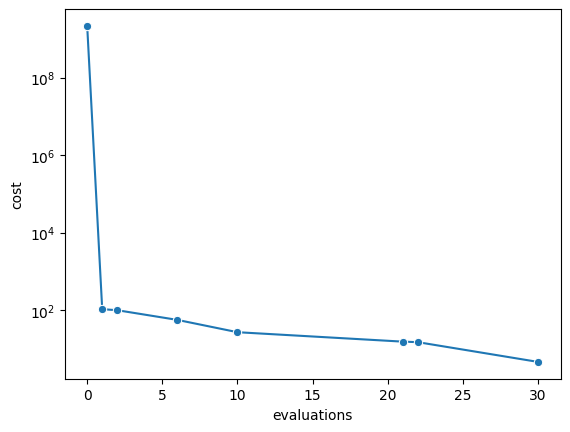

In [14]:
# Visualize trajectory
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def read_jsonl(fn: str) -> list:
    with open(fn, 'r') as file:
        lines = file.readlines()
    data = [json.loads(l) for l in lines]
    return data

smac_outdir = Path("/home/benjamin/Dokumente/code/tmp/rl-ws22-ex01/logs/smac/run_855218879")
trajectory_fn = smac_outdir / "traj.json"
trajectory = pd.DataFrame(read_jsonl(trajectory_fn))

ax = sns.lineplot(data=trajectory, x="evaluations", y="cost", marker="o")
ax.set_yscale("log")
plt.show()

